In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import lightgbm as lgb
import xgboost as xgb
import utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve


%matplotlib inline

In [3]:
# data = pd.read_csv("../data/UCI_Credit_Card.csv")
# X_train, X_test, y_train, y_test = train_test_split(
#     data.drop(['default.payment.next.month','ID'],axis=1),
#     data['default.payment.next.month'] ,
#     test_size=0.33, 
#     random_state=42
# )


In [62]:
def shuffle_y(y, *, nshuff= 50):
    index_1 = y[y==1].sample(nshuff).index
    index_0 = y[y==0].sample(nshuff).index
    y.loc[index_1]=0
    y.loc[index_0]=1
    
    return y

data = pd.read_csv("../data/creditcard.csv")


y = data['Class'] 
y = shuffle_y(y, nshuff = 75)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Class','Time'],axis=1),
    y ,
    test_size=0.33, 
    random_state=42
)

/Users/sandro/.miniconda/installation/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [63]:
y_test.value_counts()

0    93840
1      147
Name: Class, dtype: int64

In [64]:
y_test.value_counts(normalize=True).apply(lambda x: round(x,3))

0    0.998
1    0.002
Name: Class, dtype: float64

In [65]:
weight = y_train.value_counts().loc[0]/y_train.value_counts().loc[1]
weight

552.1014492753624

### Some handy functions

### train a default model

In [66]:
# def_model = lgb.LGBMClassifier(num_leaves = 10, n_estimators=100)
def_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, max_depth=3)

def_model = utils.fit_model(def_model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)
# plot_logloss(def_model)
utils.eval_model(def_model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)


Train
{'auc': 0.9742}

Test
{'auc': 0.9104}


In [67]:
# pd.Series(def_model.feature_importances_, index = X_train.columns).sort_values(ascending=False)

### train a model with rescaling

In [68]:
# import lightgbm as lgb
# rescaled_model = lgb.LGBMClassifier(num_leaves = 10, n_estimators=100, class_weight = "balanced")#{1:3,0:1})
rescaled_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, max_depth=3, scale_pos_weight=weight)
# rescaled_model = lgb.LGBMClassifier(num_leaves = 4, n_estimators=20)

rescaled_model = utils.fit_model(rescaled_model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)
# plot_logloss(rescaled_model)
utils.eval_model(rescaled_model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)


Train
{'auc': 0.9998}

Test
{'auc': 0.8696}


In [69]:
weight

552.1014492753624

In [70]:
# np.clip?

In [71]:
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = np.clip(y_train.value_counts().loc[1]*weight/y_train.value_counts().loc[0],0,1)

# RandomOverSampler
ros = RandomOverSampler(sampling_strategy=sampling_strategy,random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampled_model = lgb.LGBMClassifier(num_leaves = 10, n_estimators=100)
oversampled_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, max_depth=3)

oversampled_model = utils.fit_model(oversampled_model, X_train = X_train_resampled, y_train = y_train_resampled, X_test = X_test, y_test = y_test)
# plot_logloss(def_model)
utils.eval_model(def_model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)


Train
{'auc': 0.9742}

Test
{'auc': 0.9104}


### Using weighted cross-entropy

In [72]:
xgb.DMatrix

xgboost.core.DMatrix

In [73]:
from bokbokbok.loss_functions.classification import WeightedCrossEntropyLoss
from bokbokbok.eval_metrics.classification import WeightedCrossEntropyMetric
from bokbokbok.utils import clip_sigmoid
train = xgb.DMatrix(X_train, y_train)
test = xgb.DMatrix(X_test, y_test)
params = {
     'n_estimators': 100,
     'num_leaves': 10,
    'max_depth':3,
#     'metric':["binary"]
    'objective':'binary:logistic'
   }

alpha=weight

weighted_loss_model = xgb.train(params=params,
                 dtrain=train,
          num_boost_round=300,
          early_stopping_rounds=10,
          verbose_eval=10,
          obj=WeightedCrossEntropyLoss(alpha=alpha),
          maximize=False,
          feval=WeightedCrossEntropyMetric(alpha=alpha, XGBoost=True),
          evals=[(train, 'dtrain'), (test, 'test')])

# roc_auc_score(y_test,weighted_loss_model.predict(X_test))

[09:51:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:51:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	dtrain-logloss:0.52425	dtrain-WCE_alpha552.1014492753624:1.06148	test-logloss:0.52418	test-WCE_alpha552.1014492753624:1.02009
[10]	dtrain-logloss:0.19699	dtrain-WCE_alpha552.1014492753624:0.47371	test-logloss:0.19786	test-WCE_alpha552.1014492753624:0.62115
[20]	dtrain-logloss:0.15281	dtrain-WCE_alpha552.1014492753624:0.34576	test-logloss:

In [74]:
roc_auc_score(y_test,weighted_loss_model.predict(test))

0.898159843647604

In [75]:
log_odds = lambda x: np.log((1-x)/x)

In [76]:
xgb.plot_tree?

Signature:
xgb.plot_tree(
    booster,
    fmap='',
    num_trees=0,
    rankdir=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot specified tree.

Parameters
----------
booster : Booster, XGBModel
    Booster or XGBModel instance
fmap: str (optional)
   The name of feature map file
num_trees : int, default 0
    Specify the ordinal number of target tree
rankdir : str, default "TB"
    Passed to graphiz via graph_attr
ax : matplotlib Axes, default None
    Target axes instance. If None, new figure and axes will be created.
kwargs :
    Other keywords passed to to_graphviz

Returns
-------
ax : matplotlib Axes
File:      ~/.miniconda/installation/envs/py38/lib/python3.8/site-packages/xgboost/plotting.py
Type:      function


In [77]:
xgb.plot_tree?

Signature:
xgb.plot_tree(
    booster,
    fmap='',
    num_trees=0,
    rankdir=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot specified tree.

Parameters
----------
booster : Booster, XGBModel
    Booster or XGBModel instance
fmap: str (optional)
   The name of feature map file
num_trees : int, default 0
    Specify the ordinal number of target tree
rankdir : str, default "TB"
    Passed to graphiz via graph_attr
ax : matplotlib Axes, default None
    Target axes instance. If None, new figure and axes will be created.
kwargs :
    Other keywords passed to to_graphviz

Returns
-------
ax : matplotlib Axes
File:      ~/.miniconda/installation/envs/py38/lib/python3.8/site-packages/xgboost/plotting.py
Type:      function


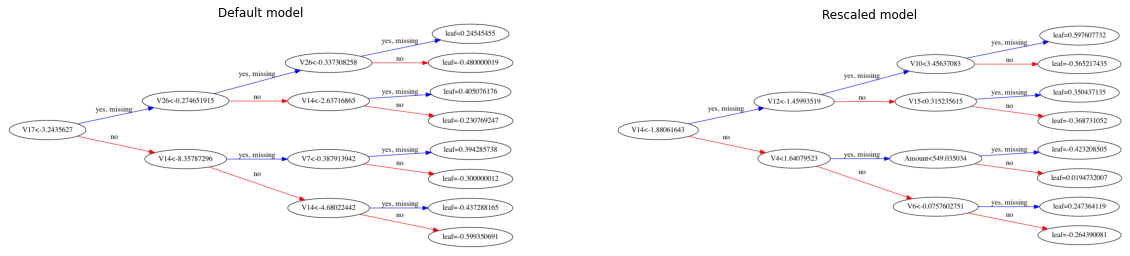

In [78]:
fig, ax = plt.subplots(1,2,figsize=(20,15))
xgb.plot_tree(def_model,num_trees=0, ax=ax[0],rankdir='LR')
xgb.plot_tree(rescaled_model,num_trees=0, ax=ax[1],rankdir='LR')
ax[0].set_title("Default model")
ax[1].set_title("Rescaled model")
# xgb.plot_tree(oversampled_model,num_trees=0, ax=ax[0][1],rankdir='LR')
# xgb.plot_tree(weighted_loss_model,num_trees=0, ax=ax[1][1],rankdir='LR')
# xgb.plot_tree(def_model,num_trees=0, ax=ax[0][0],rankdir='LR')
# xgb.plot_tree(rescaled_model,num_trees=0, ax=ax[1][0],rankdir='LR')
# xgb.plot_tree(oversampled_model,num_trees=0, ax=ax[0][1],rankdir='LR')
# xgb.plot_tree(weighted_loss_model,num_trees=0, ax=ax[1][1],rankdir='LR')

# ax[0][0].set_title("Default model")
# ax[1][0].set_title("Rescaled model")
# ax[0][1].set_title("Oversampling model")
# ax[1][1].set_title("Weighted loss model")
plt.show()

In [79]:
round_int = 7

proba_def=np.round(def_model.predict_proba(X_test)[:,1],round_int)
proba_rescaled=np.round(rescaled_model.predict_proba(X_test )[:,1],round_int)
proba_oversampled=np.round(oversampled_model.predict_proba(X_test )[:,1],round_int)
proba_weightedloss=np.round(weighted_loss_model.predict(test),round_int)

logodds_def_raw=log_odds(proba_def)
logodds_rescaled_raw=log_odds(proba_rescaled)
logodds_oversampled_raw=log_odds(proba_oversampled)
logodds_weightedloss_raw=log_odds(proba_weightedloss)

# logodds_def_raw=def_model.predict_proba(X_test, raw_score=True)
# logodds_rescaled_raw=rescaled_model.predict_proba(X_test, raw_score=True)
# logodds_oversampled_raw=oversampled_model.predict_proba(X_test, raw_score=True)
# logodds_weightedloss_raw=weighted_loss_model.predict(test, raw_score=True)

df_scores = pd.DataFrame(
    {
      'proba_default':proba_def,
      'proba_rescaled':proba_rescaled,
      'proba_oversampled':proba_oversampled,
      'proba_weightedloss':proba_weightedloss,
      'log_odds_default':logodds_def_raw,
      'log_odds_rescaled':logodds_rescaled_raw,
      'log_odds_oversampled':logodds_oversampled_raw,
      'log_odds_weightedloss':logodds_weightedloss_raw,
      'y':y_test
        
    }
).sort_values(by='log_odds_default').reset_index(False)

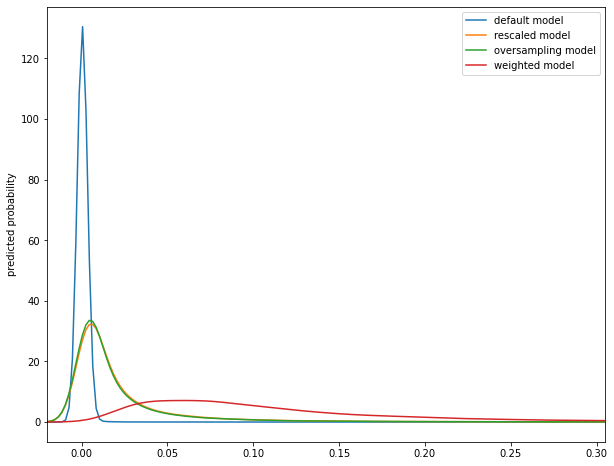

In [82]:
fig, ax = plt.subplots(figsize=(10,8))
pd.Series(proba_def).plot(kind='kde', ax=ax, label = "default model")
pd.Series(proba_rescaled).plot(kind='kde',ax=ax, label = "rescaled model")
pd.Series(proba_oversampled).plot(kind='kde',ax=ax, label = "oversampling model")
pd.Series(proba_weightedloss).plot(kind='kde',ax=ax, label = "weighted model")

# ax.set_xlim(-0.05,1.05)
ax.set_xlim(-0.02,0.305)
ax.set_ylabel("predicted probability")
ax.legend()


In [20]:
df_scores

,index,proba_default,proba_rescaled,proba_oversampled,proba_weightedloss,log_odds_default,log_odds_rescaled,log_odds_oversampled,log_odds_weightedloss,y
0,9194,0.889547,0.900552,0.870878,0.954415,-2.086120,-2.203372,-1.908741,-3.041524,1
1,13369,0.887592,0.976876,0.983118,0.950443,-2.066380,-3.743479,-4.064452,-2.953805,1
2,14950,0.881980,0.971978,0.962976,0.968339,-2.011320,-3.546355,-3.258453,-3.420507,1
3,4447,0.875434,0.958233,0.962003,0.946782,-1.949880,-3.132989,-3.231505,-2.878675,0
4,28851,0.870863,0.966598,0.963377,0.959759,-1.908611,-3.365174,-3.269755,-3.171808,1
...,...,...,...,...,...,...,...,...,...,...
9895,23363,0.021570,0.272329,0.125455,0.165381,3.814636,0.982838,1.941756,1.618723,0
9896,9303,0.021566,0.097117,0.102934,0.060146,3.814845,2.229680,2.165047,2.748944,0
9897,25771,0.020655,0.043653,0.046239,0.080273,3.858922,3.086839,3.026583,2.438650,1
9898,23476,0.020356,0.022094,0.034154,0.043620,3.873814,3.790112,3.342137,3.087644,0


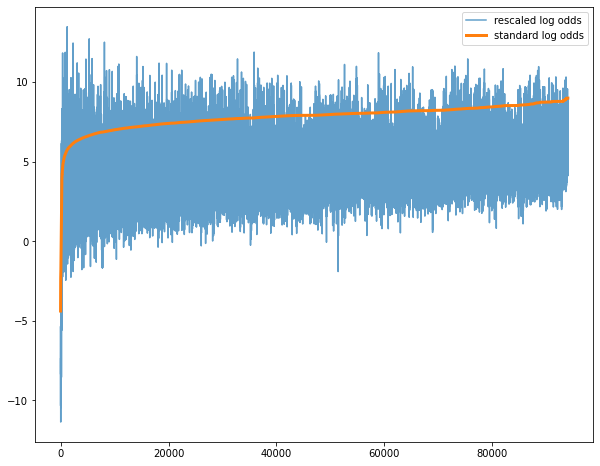

In [83]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df_scores.index,df_scores['log_odds_rescaled'],label='rescaled log odds',alpha=0.7)
ax.plot(df_scores.index,df_scores['log_odds_default'],label='standard log odds', linewidth=3)
# ax.plot(df_scores.index,df_scores['log_odds_oversampled'],label='oversampled log odds',alpha=0.3)
# ax.plot(df_scores.index,df_scores['log_odds_weightedloss'],label='weightedloss log odds',alpha=0.3)
ax.legend()


In [84]:

def_stats = utils.agg_buckets(df_scores, col = 'log_odds_default',q=8)
resc_stats = utils.agg_buckets(df_scores, col = 'log_odds_rescaled',q=8)
oversamp_stats = utils.agg_buckets(df_scores, col = 'log_odds_oversampled',q=8)
wl_stats = utils.agg_buckets(df_scores, col = 'log_odds_weightedloss',q=8)

In [85]:
print("default model")
display(def_stats)
# print(def_stats['iv'].sum())
print("rescaled model")
display(resc_stats)
print(resc_stats['iv'].sum())
# print("rescaled model")
# display(oversamp_stats)
# print(oversamp_stats['iv'].sum())

default model


,tot_entries,tot_goods,tot_def,def_rate,mean_proba,mean_proba_resc,mean_proba_oversampled,mean_proba_weightedloss,woe,iv
0,11751,11632,119,0.010127,0.011107,0.085809,0.081808,0.266717,-1.876522,1.286484
1,11747,11740,7,0.000596,0.000671,0.036677,0.037325,0.163609,0.965933,0.074848
2,12335,12327,8,0.000649,0.000483,0.026690,0.026407,0.131024,0.881192,0.067799
3,11318,11317,1,0.000088,0.000387,0.021318,0.021633,0.110099,2.875147,0.327181
4,11593,11589,4,0.000345,0.000336,0.015255,0.014817,0.094445,1.512603,0.145643
5,12114,12109,5,0.000413,0.000284,0.013972,0.012941,0.085622,1.333352,0.126702
6,11382,11381,1,0.000088,0.000234,0.008979,0.008310,0.063574,2.880787,0.329787
7,11747,11745,2,0.000170,0.000173,0.007827,0.005882,0.047120,2.219122,0.247553


rescaled model


,tot_entries,tot_goods,tot_def,def_rate,mean_proba,mean_proba_resc,mean_proba_oversampled,mean_proba_weightedloss,woe,iv
0,11749,11635,114,0.009703,0.010400,0.136046,0.111407,0.272259,-1.833339,1.194462
1,11748,11745,3,0.000255,0.000626,0.034931,0.035289,0.163025,1.813657,0.189984
2,11749,11745,4,0.000340,0.000517,0.019232,0.022101,0.130971,1.525975,0.149468
3,11748,11740,8,0.000681,0.000475,0.011732,0.015334,0.110711,0.832402,0.058838
4,11748,11743,5,0.000426,0.000443,0.007348,0.010767,0.093427,1.302661,0.118705
5,11748,11743,5,0.000426,0.000422,0.004495,0.007528,0.080887,1.302661,0.118705
6,11748,11745,3,0.000255,0.000404,0.002427,0.004751,0.066227,1.813657,0.189984
7,11749,11744,5,0.000426,0.000398,0.000829,0.002428,0.046673,1.302746,0.118727


2.1388711190792096


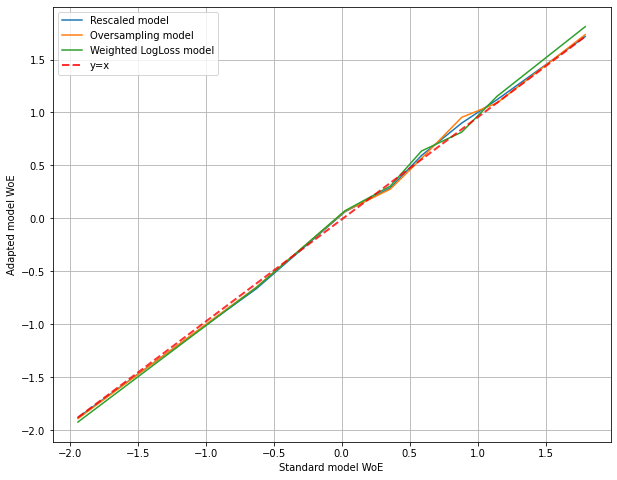

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(def_stats['woe'], resc_stats['woe'], label ='Rescaled model')
ax.plot(def_stats['woe'], oversamp_stats['woe'], label ='Oversampling model')
ax.plot(def_stats['woe'], wl_stats['woe'], label ='Weighted LogLoss model')
ax.plot([def_stats['woe'].min(), def_stats['woe'].max()], [resc_stats['woe'].min(), resc_stats['woe'].max()], linestyle='--', lw=2, color='r',
        label='y=x', alpha=.8)
ax.set_xlabel("Standard model WoE")
ax.set_ylabel("Adapted model WoE")
ax.grid()
ax.legend()

In [25]:
oversamp_stats.head(2)

,tot_entries,tot_goods,tot_def,def_rate,mean_proba,mean_proba_resc,mean_proba_oversampled,mean_proba_weightedloss,woe,iv
0,1238,435,803,0.648627,0.657925,0.865798,0.871429,0.862459,-1.890487,0.597237
1,1237,807,430,0.347615,0.338828,0.636320,0.651145,0.629657,-0.647940,0.061568


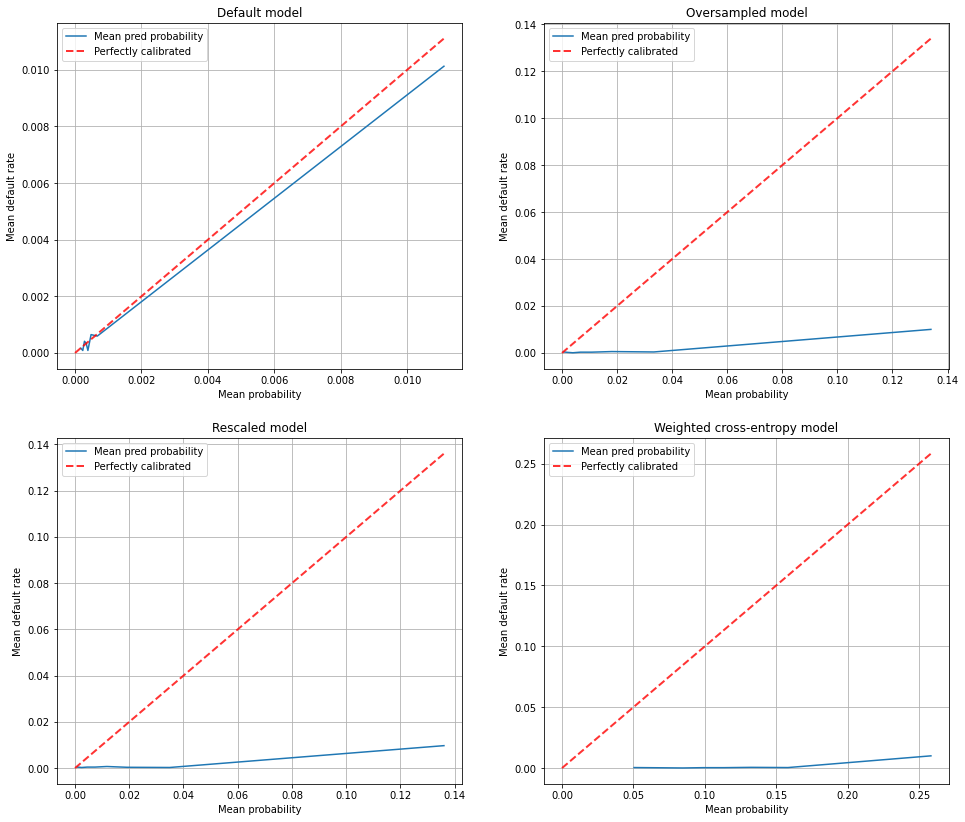

In [86]:
fig, ax = plt.subplots(2,2,figsize=(16,14))
ax[0][0].plot(def_stats['mean_proba'], def_stats['def_rate'],label="Mean pred probability")
# ax[0][0].plot([def_stats['mean_proba'].min(), def_stats['mean_proba'].max()], [def_stats['def_rate'].min(), def_stats['def_rate'].max()], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
ax[0][0].plot([0, def_stats['mean_proba'].max()], [0,def_stats['mean_proba'].max()], linestyle='--', lw=2, color='r',
        label='Perfectly calibrated', alpha=.8)
ax[0][0].set_xlabel("Mean probability")
ax[0][0].set_ylabel("Mean default rate")
ax[0][0].grid()
ax[0][0].legend()
ax[0][0].set_title('Default model')

ax[1][0].plot(resc_stats['mean_proba_resc'], resc_stats['def_rate'],label="Mean pred probability")
# ax[1][0].plot([resc_stats['mean_proba_resc'].min(), resc_stats['mean_proba_resc'].max()], [resc_stats['def_rate'].min(), resc_stats['def_rate'].max()], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
ax[1][0].plot([0, resc_stats['mean_proba_resc'].max()], [0,resc_stats['mean_proba_resc'].max()], linestyle='--', lw=2, color='r',
        label='Perfectly calibrated', alpha=.8)
ax[1][0].set_xlabel("Mean probability")
ax[1][0].set_ylabel("Mean default rate")
ax[1][0].grid()
ax[1][0].set_title('Rescaled model')
ax[1][0].legend()

ax[0][1].plot(oversamp_stats['mean_proba_oversampled'], oversamp_stats['def_rate'],label="Mean pred probability")
# ax[0][1].plot([oversamp_stats['mean_proba_oversampled'].min(), oversamp_stats['mean_proba_oversampled'].max()], [resc_stats['def_rate'].min(), resc_stats['def_rate'].max()], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
ax[0][1].plot([0, oversamp_stats['mean_proba_oversampled'].max()], [0,oversamp_stats['mean_proba_oversampled'].max()], linestyle='--', lw=2, color='r',
        label='Perfectly calibrated', alpha=.8)
ax[0][1].set_xlabel("Mean probability")
ax[0][1].set_ylabel("Mean default rate")
ax[0][1].grid()
ax[0][1].set_title('Oversampled model')
ax[0][1].legend()

ax[1][1].plot(oversamp_stats['mean_proba_weightedloss'], oversamp_stats['def_rate'],label="Mean pred probability")
# ax[1][1].plot([oversamp_stats['mean_proba_weightedloss'].min(), oversamp_stats['mean_proba_weightedloss'].max()], [resc_stats['def_rate'].min(), resc_stats['def_rate'].max()], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)
ax[1][1].plot([0, oversamp_stats['mean_proba_weightedloss'].max()], [0,oversamp_stats['mean_proba_weightedloss'].max()], linestyle='--', lw=2, color='r',
        label='Perfectly calibrated', alpha=.8)
ax[1][1].set_xlabel("Mean probability")
ax[1][1].set_ylabel("Mean default rate")
ax[1][1].grid()
ax[1][1].set_title('Weighted cross-entropy model')
ax[1][1].legend()

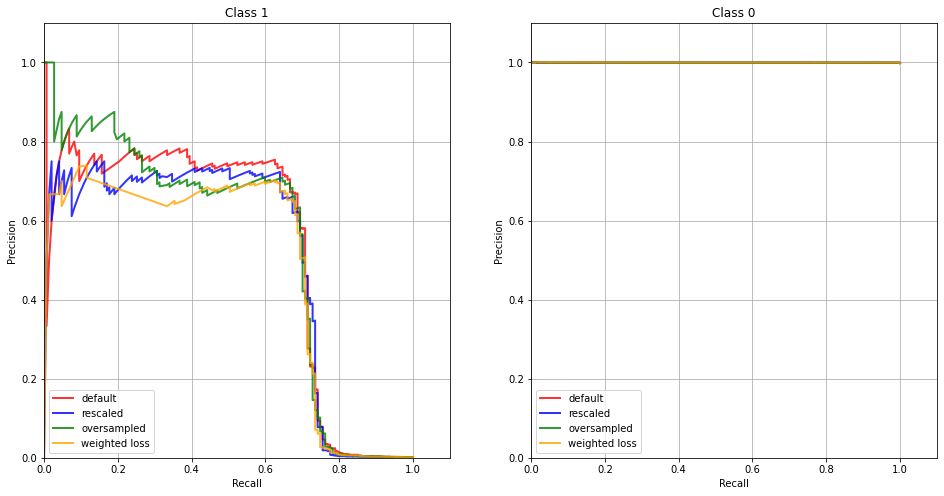

In [87]:
fig, ax = plt.subplots(1,2,figsize=(16,8))


for proba, label, color in zip(
        [proba_def,proba_rescaled, proba_oversampled, proba_weightedloss],
            ['default','rescaled', 'oversampled','weighted loss'],
            ['red','blue','green','orange']):
    
    pr_1 = precision_recall_curve(y_test,proba)
    pr_0 = precision_recall_curve(y_test,1-proba,pos_label=0)
    
    ax[0].plot(pr_1[1], pr_1[0], color=color,
            label=label,
            lw=2, alpha=.8)
    ax[1].plot(pr_0[1], pr_0[0], color=color,
        label=label,
        lw=2, alpha=.8)


ax[0].set_ylabel("Precision")
ax[0].set_xlabel("Recall")

ax[0].set_title("Class 1")
ax[0].set_ylim(0,1.1)
ax[0].set_xlim(0,1.1)
ax[0].grid()
ax[0].legend(loc = 'lower left')


ax[1].set_ylabel("Precision")
ax[1].set_xlabel("Recall")

ax[1].set_title("Class 0")

ax[1].set_ylim(0,1.1)
ax[1].set_xlim(0,1.1)
ax[1].grid()
ax[1].legend(loc = 'lower left')

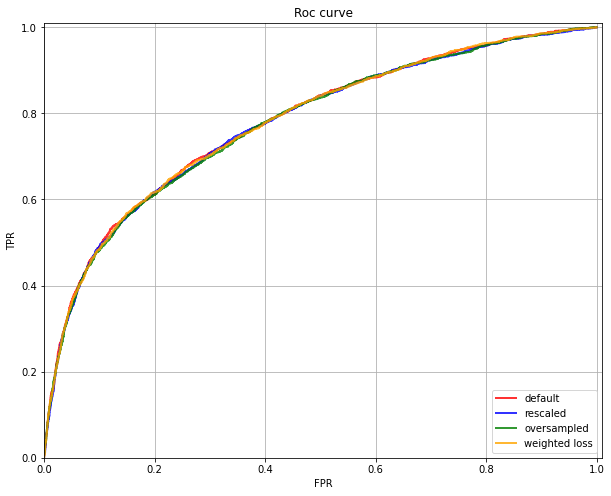

In [28]:
fig, ax = plt.subplots(figsize=(10,8))


for proba, label, color in zip(
        [proba_def,proba_rescaled, proba_oversampled, proba_weightedloss],
            ['default','rescaled', 'oversampled','weighted loss'],
            ['red','blue','green','orange']):
    
    roc = roc_curve(y_test,proba)
    
    ax.plot(roc[0], roc[1], color=color,
            label=label,
            lw=2, alpha=.8)



ax.set_ylabel("TPR")
ax.set_xlabel("FPR")

ax.set_title("Roc curve")
ax.set_ylim(0,1.01)
ax.set_xlim(0,1.01)
ax.grid()
ax.legend(loc = 'lower right')


